# Calculs

## Constantes et Facteurs d'émission 

In [94]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd


### Parametres Globaux

In [95]:
NB_ELEVES = 100
DUREE_MOOC = 10 #Heures
MIX_ELEC_FR = 0.0519 #kgCO2e/kWh

#### Terminaux 

In [96]:
RATIO_SMARTPHONE = 0.4
USAGE_SMARTPHONE_J = 3 #h 
DUREE_VIE_SMARTPHONE = 3 #ans
PUISSANCE_SMARTPHONE = 3.9 #kWh

RATIO_LAPTOP = 0.4
USAGE_LAPTOP_J = 6 #h 
DUREE_VIE_LAPTOP = 3 #ans
PUISSANCE_LAPTOP = 29.1#kWh

RATIO_DESKTOP = 0.2
USAGE_DESKTOP_J = 3 #h 
DUREE_VIE_DESKTOP = 3 #ans
PUISSANCE_DESKTOP = 100 +70#kWh



#### Serveur

In [97]:
ALLOCATION_SERVEUR = 0.05
PUE = 1.6
DUREE_VIE_SERVEUR =  5 # ans 
PUISSANCE_SERVEUR_A = 1805 #KWh

#### Réseau 

In [98]:
POIDS_VIDEO_GO_H = 1 #Go/h
CONSO_RESEAU_FIXE = 0.05 #kWh/Go
CONSO_RESEAU_MOBILE =  0.24 #kWh/Go arcep
RATIO_FIXE = 0.6 # Utilisation de wifi 
RATIO_MOBILE = 0.4 # Réseau céllulaire
IMPACT_TRANSFERT_FIXE_GO= 0.00124 #kgCO2e
IMPACT_TRANSFERT_MOBIE_GO = 0.0131

In [99]:



# 2. Création du Tableau avec les données brutes (Source : Tes fichiers CSV)
# Note : Pour le PC Fixe, j'ai additionné la Tour (259) + l'Ecran (64.6) = 323.6
data = {
    'Type_Equipement': ['Smartphone', 'Ordinateur Portable', 'PC Fixe + Écran'],
    
    # Données Fabrication (Source : Base Empreinte - Equipements Fabrication)
    'Impact_Fab_Total_kgCO2e': [77.0, 170.0, 323.6],
    
    # Hypothèses d'usage (Source : Tes choix de modélisation)
    'Puissance_W': [2, 20, 105],        # 105W = 75W PC + 30W Ecran
    'Duree_Vie_Ans': [2.5, 4, 5],       # Durée de détention moyenne
    'Usage_Journalier_H': [4, 5, 4],    # Estimation pour calcul amortissement
    
    # Répartition des 100 élèves
    'Nombre_Eleves': [40, 40, 20]
}

df_terminaux = pd.DataFrame(data)

# ---------------------------------------------------------
# 3. MOTEUR DE CALCUL (Automatique)
# ---------------------------------------------------------

# A. Calcul du temps de vie total en heures (pour l'amortissement)
# Formule : Années * 365 jours * Heures/jour
df_terminaux['Heures_Vie_Totale'] = df_terminaux['Duree_Vie_Ans'] * 365 * df_terminaux['Usage_Journalier_H']

# B. Calcul de l'Impact Fabrication Amorti (pour 10h de MOOC)
# On prend l'impact total et on ne garde que la portion correspondant aux 10h
df_terminaux['Impact_Fab_Amorti_kgCO2e'] = (
    df_terminaux['Impact_Fab_Total_kgCO2e'] / df_terminaux['Heures_Vie_Totale']
) * DUREE_MOOC

# C. Calcul de l'Impact Usage (Consommation électrique)
# Energie (kWh) = Puissance (W) / 1000 * Heures
df_terminaux['Energie_Conso_kWh'] = (df_terminaux['Puissance_W'] / 1000) * DUREE_MOOC
df_terminaux['Impact_Usage_kgCO2e'] = df_terminaux['Energie_Conso_kWh'] * MIX_ELEC_FR

# D. Total Unitaire (Fab + Usage pour 1 élève)
df_terminaux['Total_Unitaire_kgCO2e'] = df_terminaux['Impact_Fab_Amorti_kgCO2e'] + df_terminaux['Impact_Usage_kgCO2e']

# E. Total pour la promo (pondéré par le nombre d'élèves)
df_terminaux['Total_Promo_kgCO2e'] = df_terminaux['Total_Unitaire_kgCO2e'] * df_terminaux['Nombre_Eleves']

# ---------------------------------------------------------
# 4. Affichage du résultat
# ---------------------------------------------------------

# On arrondit pour la lisibilité
pd.options.display.float_format = '{:.4f}'.format

print("--- TABLEAU DE SYNTHÈSE : TERMINAUX UTILISATEURS ---")
display(df_terminaux[['Type_Equipement', 'Impact_Fab_Amorti_kgCO2e', 'Impact_Usage_kgCO2e', 'Total_Unitaire_kgCO2e', 'Total_Promo_kgCO2e']])

# Vérification du total global
total_co2_terminaux = df_terminaux['Total_Promo_kgCO2e'].sum()
print(f"\n IMPACT TOTAL TERMINAUX (100 élèves) : {total_co2_terminaux:.2f} kg CO2e")

--- TABLEAU DE SYNTHÈSE : TERMINAUX UTILISATEURS ---


,Type_Equipement,Impact_Fab_Amorti_kgCO2e,Impact_Usage_kgCO2e,Total_Unitaire_kgCO2e,Total_Promo_kgCO2e
0,Smartphone,0.2110,0.0010,0.2120,8.4799
1,Ordinateur Portable,0.2329,0.0104,0.2433,9.7303
2,PC Fixe + Écran,0.4433,0.0545,0.4978,9.9557



 IMPACT TOTAL TERMINAUX (100 élèves) : 28.17 kg CO2e


## Calculs terminaux utilisateurs 

### Extraction des données 

In [100]:
import pandas as pd

#
df_source_fabrication = pd.read_csv('./csv/bdd_numérique_empreinte_Fabrication.csv', header=1)
df_source_fabrication.columns = df_source_fabrication.columns.str.strip()
df_source_usage = pd.read_csv('./csv/bdd_numérique_empreinte_Usage.csv', header=1)
df_source_usage.columns =df_source_usage.columns.str.strip()



def get_gwp_fabrication(nom_equipement_ademe):
    # On cherche la ligne qui contient le nom exact
    ligne = df_source_fabrication[df_source_fabrication['Données équipements'] == nom_equipement_ademe]
    
    if not ligne.empty:
        # On récupère la valeur et on convertit en float  
        valeur = ligne['PEF-GWP'].values[0]
        valeur = float(valeur.replace(",","."))
        return valeur
    else:
        print(f"Attention : '{nom_equipement_ademe}' introuvable dans le CSV")
        return 0.0
    
def get_puissance(nom_equipement_ademe):
    # On cherche la ligne qui contient le nom exact
    ligne = df_source_usage[df_source_usage['Données équipements'] == nom_equipement_ademe]
    
    if not ligne.empty:
        # On récupère la valeur et on convertit en float  
        valeur = ligne["Quantité d'électricité nécessaire pour le procédé (kWh)"].values[0]
        valeur = float(valeur.replace(",","."))
        return valeur
    else:
        print(f"Attention : '{nom_equipement_ademe}' introuvable dans le CSV")
        return 0.0

# 4. Extraction automatique des valeurs pour tes équipements
# Note : On utilise les noms exacts trouvés dans le CSV
gwp_smartphone_fabrication = get_gwp_fabrication("Smartphone")
gwp_laptop_fabrication = get_gwp_fabrication("Ordinateur portable")
gwp_pc_tour_fabrication = get_gwp_fabrication("Ordinateur fixe (sans écran) personnel")
gwp_ecran_fabrication = get_gwp_fabrication("Ecran d'ordinateur")

# puissance_smartphone = get_puissance("Smartphone usage personnel")
# puissance_laptop = get_puissance("Ordinateur portable personnel")
# puissance_pc_tour = get_puissance("Ordinateur fixe (sans écran) personnel")
# puissance_ecran = get_puissance("Ecran d'ordinateur")
# Calcul du PC Fixe complet (Tour + Écran)
gwp_pc_fixe_complet_fabrication = gwp_pc_tour_fabrication + gwp_ecran_fabrication

#Calculs de l'impact totale de la fabrication 
impact_total_fabrication_terminaux = gwp_pc_fixe_complet_fabrication +gwp_laptop_fabrication+gwp_smartphone_fabrication
print("--- Valeurs extraites du CSV (kg CO2e) ---")
print(f"Smartphone : {gwp_smartphone_fabrication}")
print(f"Laptop : {gwp_laptop_fabrication}")
print(f"PC Fixe (Complet) : {gwp_pc_fixe_complet_fabrication}")
print(f"Impact totale: {impact_total_fabrication_terminaux}")

# -----------------------------------------------------------
# TU PEUX MAINTENANT UTILISER CES VARIABLES DANS TON DATAFRAME
# -----------------------------------------------------------

data = {
    'Type_Equipement': ['Smartphone', 'Ordinateur Portable', 'PC Fixe + Écran'],
    
    # On utilise ici les variables extraites au lieu des chiffres "en dur"
    'Impact_Fab_Total_kgCO2e': [gwp_smartphone_fabrication, gwp_laptop_fabrication, gwp_pc_fixe_complet_fabrication],
    'Puissance_W': [2, 20, 105],
    'Duree_Vie_Ans': [2.5, 4, 5],
    'Usage_Journalier_H': [4, 6, 4],
    'Nombre_Eleves': [40, 40, 20]
}



--- Valeurs extraites du CSV (kg CO2e) ---
Smartphone : 77.0
Laptop : 170.0
PC Fixe (Complet) : 323.6
Impact totale: 570.6


### Amortissement de la fabrication 

$$ \text{Impact}_{\text{Total Fab Amorti}}=  \text{Impact}_{\text{Total Fab}} \times \frac{\text{Duree Mooc (10h)}}{\text{Duree de vie (annee)} \times 365 \times \text{Heure Usage jour}(h)} $$

Valeur de l'impact amorti de la fabrication

In [101]:
impact_fabrication_smartphone = gwp_smartphone_fabrication * DUREE_MOOC/(DUREE_VIE_SMARTPHONE * 365  * USAGE_SMARTPHONE_J)
impact_fabrication_desktop = gwp_pc_fixe_complet_fabrication * DUREE_MOOC/(DUREE_VIE_DESKTOP * 365  * USAGE_DESKTOP_J)
impact_fabrication_laptop = gwp_laptop_fabrication * DUREE_MOOC/(DUREE_VIE_LAPTOP * 365  * USAGE_LAPTOP_J)
print(impact_fabrication_smartphone, impact_fabrication_desktop, impact_fabrication_laptop)

0.2343987823439878 0.9850837138508372 0.258751902587519


### Impact Usage 


étude de l'impact par étudiant en comparant chaque appareils $$ \text{Impact}_{\text{Usage}} = \text{Puissance appareil(kW)} \times 10 h \times \text{Mix Elec Français} $$ 

In [102]:
impact_usage_smartphone = PUISSANCE_SMARTPHONE * 10 * MIX_ELEC_FR
impact_usage_desktop = PUISSANCE_DESKTOP * 10 * MIX_ELEC_FR
impact_usage_laptop = PUISSANCE_LAPTOP * 10 * MIX_ELEC_FR
print(impact_usage_smartphone,impact_usage_desktop,impact_fabrication_laptop)

2.0241000000000002 88.23 0.258751902587519


### Impact total 

$$ I_{\text{Total Appareil}} = I_{\text{Fab}} + I_{\text{Usage}} $$

Somme pondéré pour déduire l'impact dans ce notre cas 
$$ (I_{\text{Total Tel}} \times 40) + (I_{\text{Total Laptop}} \times 40) + (I_{\text{Total FIxe}} \times 20) $$

In [103]:
impact_total_smartphone = impact_fabrication_smartphone + impact_usage_smartphone
impact_total_laptop= impact_fabrication_laptop+ impact_usage_laptop
impact_total_desktop = impact_fabrication_desktop + impact_usage_desktop
impact_terminaux_total = impact_total_smartphone + impact_total_laptop + impact_total_desktop
print(impact_total_smartphone, impact_total_desktop,impact_total_laptop)

2.258498782343988 89.21508371385085 15.36165190258752


## Calculs serveurs 

### Extraction des donnéee

In [104]:

# 1 "Fabrication"
# On précise header=1 car la vraie ligne de titres est la 2ème ligne
df_source_fabrication = pd.read_csv('./csv/bdd_numérique_empreinte_Fabrication.csv', header=1)

# 2. Nettoyage des noms de colonnes (enlève les espaces invisibles type 'PEF-GWP ')
df_source_fabrication.columns = df_source_fabrication.columns.str.strip()

# 4. Extraction automatique des valeurs pour tes équipements
# Note : On utilise les noms exacts trouvés dans le CSV
gwp_serveur_fabrication = get_gwp_fabrication("Serveur rack - moyen")


print("--- Valeurs extraites du CSV (kg CO2e) ---")
print(f"Serveur rack moyen : {gwp_serveur_fabrication}")


--- Valeurs extraites du CSV (kg CO2e) ---
Serveur rack moyen : 698.0


### Amortissement fabrication 

$$\text{Impact fabrication amorti} = \frac{\text{Impact Fab Total}}{\text{Duree de vie}} \times \text{Allocation}$$

In [105]:
impact_fabrication_serveur =(gwp_serveur_fabrication/DUREE_VIE_SERVEUR) *ALLOCATION_SERVEUR
print(impact_fabrication_serveur) #kgeCO2


6.98


### Impact de l'usage annuel 

$$ \text{Energie Totale} = \text{Puissance} \times \text{PUE} \times \text{Allocation}$$
$$ \text{Impact} = \text{Energie Total} \times \text{Mix Elec Français}$$


In [106]:
energie_serveur = PUISSANCE_SERVEUR_A * PUE * ALLOCATION_SERVEUR
print(energie_serveur)
impact_usage_serveur = energie_serveur * MIX_ELEC_FR
impact_usage_serveur

144.4


7.49436

### Fin de vie serveur

$$\text{Impact Fin de vie} = \text{Impact Fin de vie total} \times \text{allocation} \times \frac{1}{\text{Duree de vie }} $$

In [107]:
gwp_serveur_fin_de_vie = 8.74
impact_fin_de_vie_serveur = gwp_serveur_fin_de_vie * ALLOCATION_SERVEUR * 1/DUREE_VIE_SERVEUR
impact_fin_de_vie_serveur
impact_serveur_total = impact_fabrication_serveur +impact_usage_serveur+ impact_fin_de_vie_serveur 
impact_serveur_total

14.561760000000001

## Calculs Réseau 

Evaluation du volume total de données 

$$ \text{VOL TOTAL} = 100 \text{Eleve} \times 10 h \times 1Go/h (débit 1080p) $$

In [108]:
volume_donnees = NB_ELEVES * DUREE_MOOC* POIDS_VIDEO_GO_H
volume_donnees

def calcul_volume_donnees(nb_eleves, duree_heures, debit_go_h):
    """
    Calcule le volume total de données transférées.
    """
    return nb_eleves * duree_heures * debit_go_h

Consommation électrique réseau

$$\text{Conso Mobile} = \text{VOL TOTAL} \times 0.40 \times \text{Conso Réseau Mobile} $$
$$\text{Conso Fixe}  = \text{VOL TOTAL} \times 0.60 \times \text{Conso Réseau Fixe} $$


In [109]:
conso_mobile = volume_donnees * RATIO_MOBILE *CONSO_RESEAU_MOBILE
conso_fixe = volume_donnees *RATIO_FIXE * CONSO_RESEAU_FIXE
conso_mobile
#KWh/Go


96.0

Impact réseau 

$$\text{Impact Reseau} =  (\text{Conso Mobile} + \text{Conso Fixe}) \times \text{Mix Elec Français }  $$

In [110]:
impact_total_reseau = (conso_mobile +conso_fixe )*MIX_ELEC_FR

def calcul_impact_reseau(vol_total_go, part_mobile, conso_mobile_kwh_go, conso_fixe_kwh_go):
    """
    Calcule la consommation électrique et l'impact carbone du réseau.
    
    Paramètres :
    - vol_total_go : Volume total de données (Go)
    - part_mobile : Pourcentage d'étudiants en 4G (ex: 0.40)
    - conso_mobile_kwh_go : Ratio énergétique 4G (kWh/Go)
    - conso_fixe_kwh_go : Ratio énergétique Wi-Fi/Fibre (kWh/Go)
    """
    
    # 1. Calcul de la part Fixe (le reste)
    part_fixe = 1.0 - part_mobile
    
    # 2. Calcul des consommations (Tes formules)
    # Conso = Volume * Part * Ratio
    conso_mobile_kwh = vol_total_go * part_mobile * conso_mobile_kwh_go
    conso_fixe_kwh = vol_total_go * part_fixe * conso_fixe_kwh_go
    
    # 3. Total Énergie Réseau
    conso_totale_kwh = conso_mobile_kwh + conso_fixe_kwh
    
    # 4. Impact Carbone
    impact_reseau_kgco2e = conso_totale_kwh * MIX_ELEC_FR
    
    return {
        "Energie_Mobile_kWh": conso_mobile_kwh,
        "Energie_Fixe_kWh": conso_fixe_kwh,
        "Energie_Totale_kWh": conso_totale_kwh,
        "Impact_Reseau_kgCO2e": impact_reseau_kgco2e
    }


### Impact totaux 

In [111]:
impact_total = impact_serveur_total + impact_terminaux_total + impact_total_reseau
print(impact_total)

127.93639439878235


## Affichage des résultat

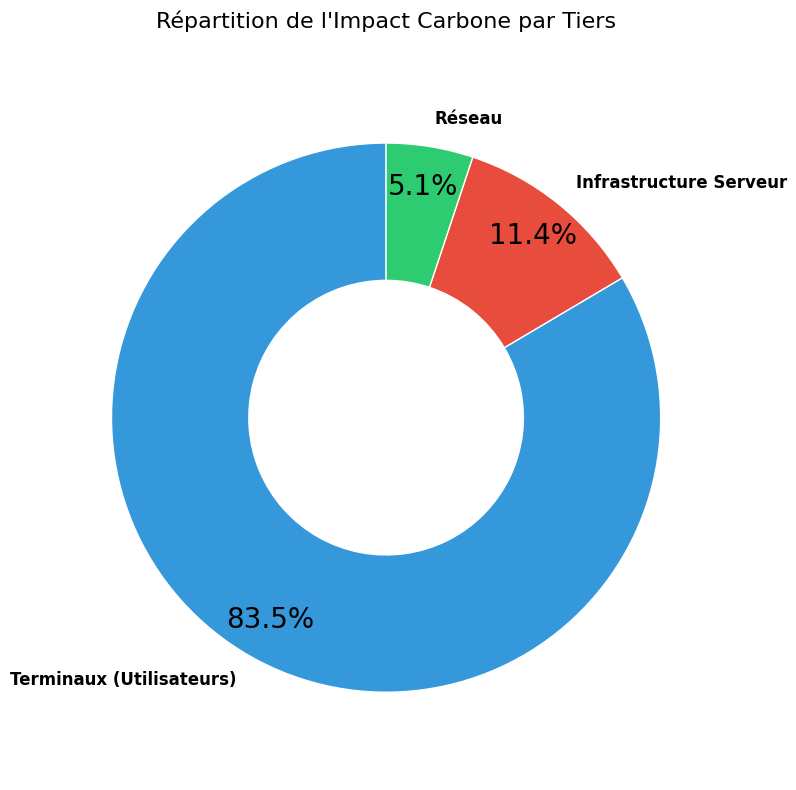

In [119]:
import matplotlib.pyplot as plt

# 1. Préparation des données
labels = ['Terminaux (Utilisateurs)', 'Infrastructure Serveur', 'Réseau']
sizes = [impact_terminaux_total, impact_serveur_total, impact_total_reseau]
colors = ['#3498db', '#e74c3c', '#2ecc71']  # Bleu, Rouge, Vert (Tons plats modernes)

# 2. Création de la figure
plt.figure(figsize=(8, 8)) # Taille carrée pour un beau rond

# 3. Création du Pie Chart
# wedgeprops : permet de créer le trou au milieu (width) et des bordures blanches
patches, texts, autotexts = plt.pie(sizes, 
                                    labels=labels, 
                                    colors=colors, 
                                    autopct='%1.1f%%', # Affiche les % avec 1 décimale
                                    startangle=90,     # Tourne le graph pour que le début soit en haut
                                    pctdistance=0.85,  # Éloigne le pourcentage du centre
                                    wedgeprops={'width': 0.5, 'edgecolor': 'w'}) # Créé l'effet Donut

# 4. Amélioration du style du texte
# On met les pourcentages en gras et en blanc s'ils sont dans la couleur, ou noir sinon
for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_fontsize(20)
    autotext.set_color('black') 

# 5. Titre et affichage
plt.title("Répartition de l'Impact Carbone par Tiers", fontsize=16, pad=20)
plt.axis('equal')  # Garantit que le camembert est bien rond
plt.tight_layout()

# Sauvegarde pour le rapport
plt.savefig("graphique_repartition_impact.png", dpi=300) 
plt.show()